In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.manifold import TSNE,MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [2]:
data = load_iris()

In [3]:
df = pd.DataFrame(data.data,columns=data.feature_names)
df['flor'] = data.target
df['flor'].replace(dict(zip(range(3),data.target_names)),inplace=True)

In [4]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),flor
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


## Visualización

In [5]:
varc = data.feature_names[:]

In [6]:
X = df[varc].copy()

In [7]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)

pca = PCA(n_components=2)
pca.fit(Xs)
pca.explained_variance_ratio_.cumsum()

Xp = pd.DataFrame(pca.transform(Xs),columns=['d1','d2'])

mds = MDS(n_components=2,n_jobs=-1)
tsne = TSNE(n_components=2,n_jobs=-1)

Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])

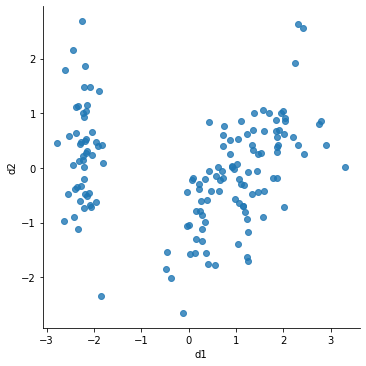

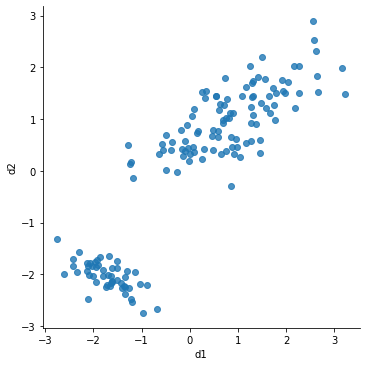

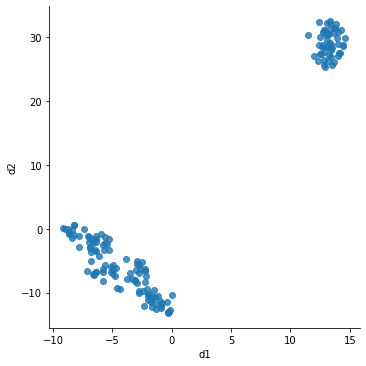

In [8]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

## Modelo no supervisado (Aglomerativo)

La metodología que se sigue es la de *Hirarchical clustering*, se busca agrupar a los datos más parecidos usando alguna función de distancia, euclidiana en este caso, y cuando ya hay clusters formados se elige un método, *average* en este caso, para probar la vinculación entre los clusters, el *linkage*. De esta forma se decide si se unen dos clusters en uno o no.

In [9]:
cluster = AgglomerativeClustering(n_clusters=3,linkage='average')

In [10]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

La función `cluster.fit_predict()` regresará un vector clasificando cada unidad muestral en alguno de los clusters.

In [11]:
Xs['cl'] = Xp['cl'] =Xm['cl'] =Xt['cl'] =cluster.fit_predict(Xs)
Xs['flor'] = Xp['flor'] =Xm['flor'] =Xt['flor'] =df['flor']

In [12]:
Xs

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cl,flor
0,0.222222,0.625000,0.067797,0.041667,0,setosa
1,0.166667,0.416667,0.067797,0.041667,0,setosa
2,0.111111,0.500000,0.050847,0.041667,0,setosa
3,0.083333,0.458333,0.084746,0.041667,0,setosa
4,0.194444,0.666667,0.067797,0.041667,0,setosa
...,...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,2,virginica
146,0.555556,0.208333,0.677966,0.750000,1,virginica
147,0.611111,0.416667,0.711864,0.791667,2,virginica
148,0.527778,0.583333,0.745763,0.916667,2,virginica


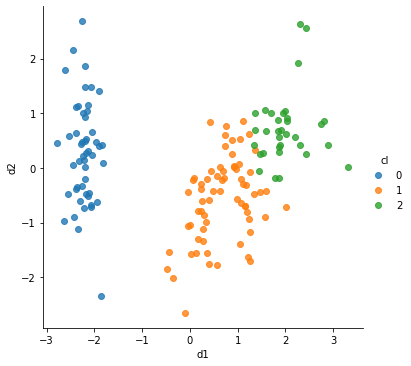

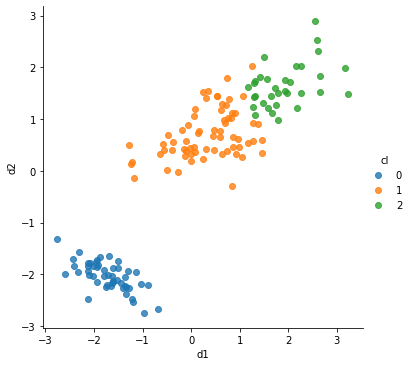

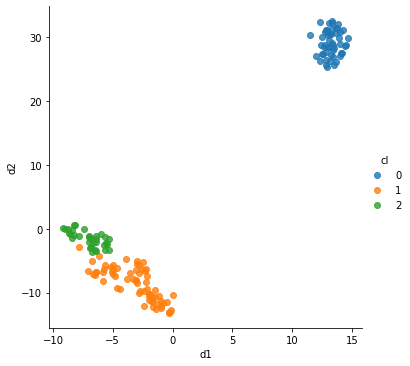

In [13]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

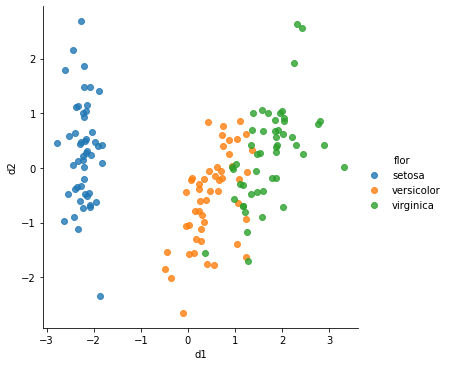

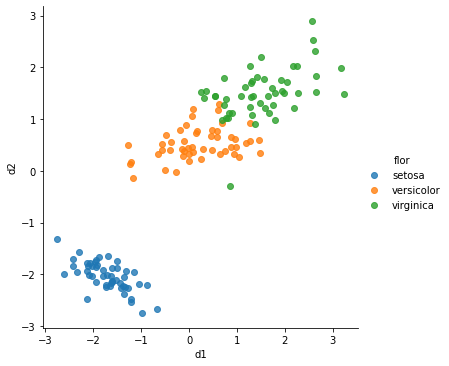

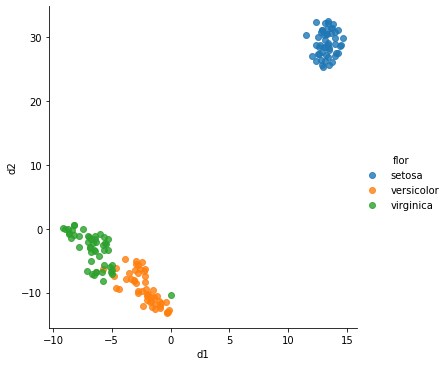

In [14]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='flor')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='flor')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='flor')

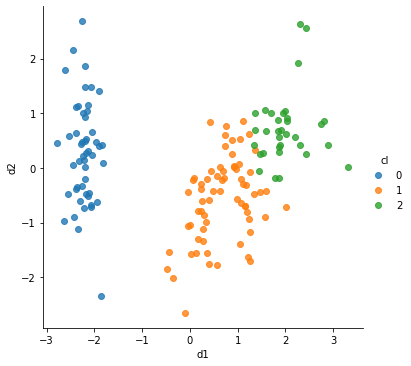

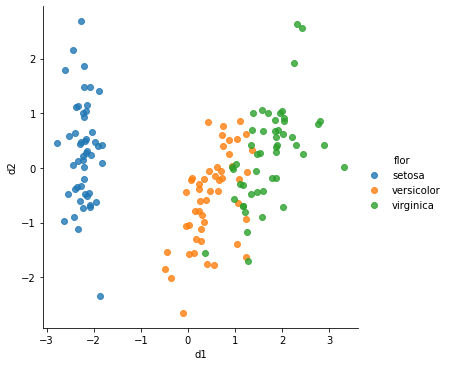

In [15]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='flor')

In [16]:
Xs[['cl','flor']].assign(n=1).pivot_table(index='cl',
                                          fill_value=0,
                                          columns='flor',
                                          values='n',
                                          aggfunc='sum')

flor,setosa,versicolor,virginica
cl,,,
0,50,0,0
1,0,50,17
2,0,0,33


## DBSCAN

Este modelo crea los clusters que cree pertinentes, pues necesita que el conjunto de puntos sea **denso** para que decida que ese es un potencial cluster, si no es denso no puede ser candidato a cluster. Para decidir si un conjunto de puntos es denso o no necesitamos dos cosas, *epsilon* será la distancia mínima, y *puntos minimos* son la cantidad mínima de puntos que están a una distancia epsilon de un punto *A* para considerar que A no es un punto atípico y que el vecindario de A podría formar un cluster. Si A forma parte de otro vecindario A se agrega a ese cluster junto con su vecindario, así se continua hasta terminar y seleccionar otro punto para clasificar como ruido o posible cluster.

In [17]:
from sklearn.cluster import DBSCAN

In [18]:
clus=DBSCAN(eps=0.3)

In [19]:
clus.fit(Xs[varc])

DBSCAN(eps=0.3)

In [20]:
Xs['cl'] = Xp['cl'] =Xm['cl'] =Xt['cl'] =clus.fit_predict(Xs[varc])

Hay que notar que las muestras etiquetadas con **-1** son detectadas como ruido por el modelo.

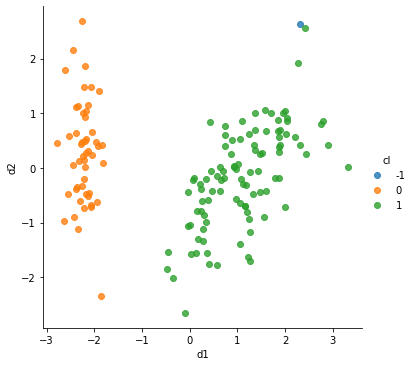

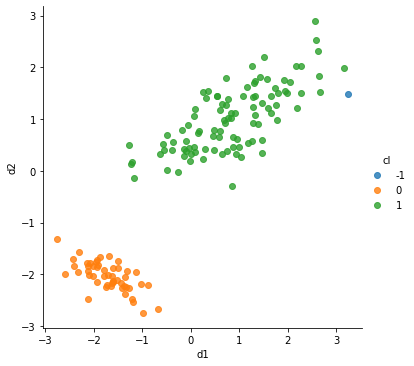

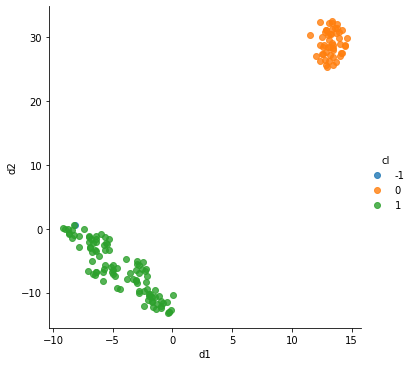

In [21]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

## K-Medias

En este caso tenemos un conjunto de datos y elegimos k **centroides** arbitrariamente, después tomamos un dato y vemos a que centroide se parece más y lo agregamos a ese cluster, una vez asignados todos los datos a algún cluster tomamos la **media** de cada cluster y repetimos el proceso ahora comparando cada dato contra la media de cada cluster, este proceso es iterativo y hay varios criterios de parada. Uno es poner un limite de iteraciones, otro es detenerse si en una iteración no cambia nada respecto a la anterior.

In [22]:
df = pd.read_excel('datos/Datos Antropométricos.xlsx')

In [23]:
varc = ['Estatura (cm)', 'Peso (kg)', 'Talla Zapato (27,28,etc)', 'Edad']

In [24]:
X = df[varc].copy()

In [25]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)

pca = PCA(n_components=2)
pca.fit(Xs)
print(pca.explained_variance_ratio_.cumsum())

Xp = pd.DataFrame(pca.transform(Xs),columns=['d1','d2'])

mds = MDS(n_components=2,n_jobs=-1)
tsne = TSNE(n_components=2,n_jobs=-1)

Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])

[0.44272375 0.70328042]


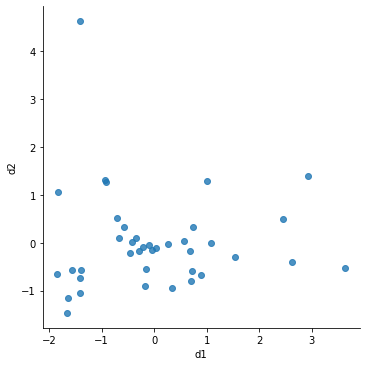

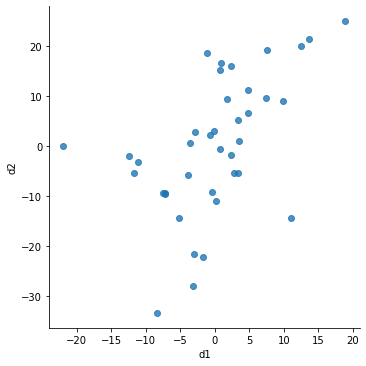

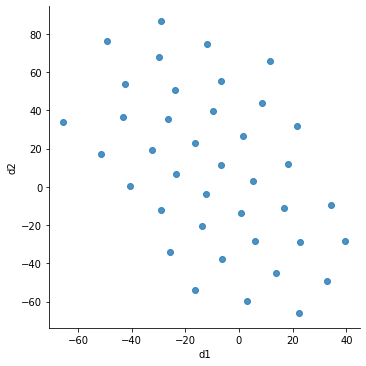

In [26]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

In [27]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

Como la inercia es la suma de los cuadrados de las distancias de la muestra hacia su mas cercano centroide, se puede medir la varianza que hay en cada cluster, así que si el valor es grande la varianza de cada cluster es grande. Naturalmente entre más clusters haya el resultado será mejor, pero hay un punto en el "codo" donde el descenso es más prununciado, ese sería el número ideal de clusters.

In [28]:
l_in = []
for k in range(2,10):
    cl = KMeans(n_clusters=k,)
    cl.fit(Xs)
    l_in.append(cl.inertia_)

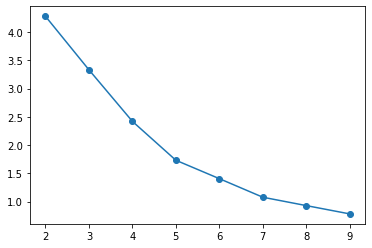

In [29]:
plt.plot(range(2,10),l_in,marker='o')

In [30]:
cluster = KMeans(n_clusters=5)

In [31]:
Xs['cl'] = Xp['cl'] = Xm['cl'] = Xt['cl'] = cluster.fit_predict(Xs)
Xs['Sexo (H,M)'] = Xp['Sexo (H,M)'] = Xm['Sexo (H,M)'] = Xt['Sexo (H,M)'] = df['Sexo (H,M)']

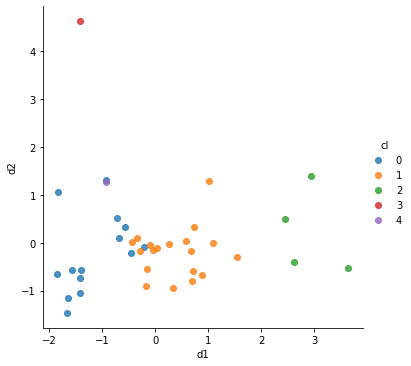

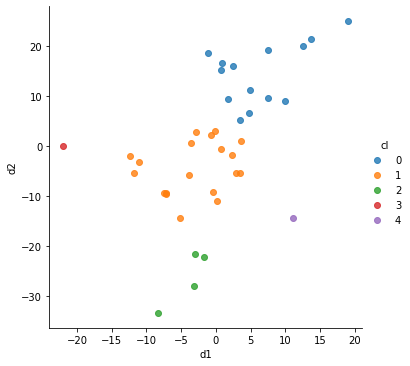

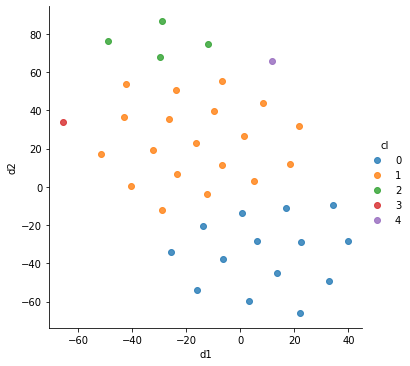

In [32]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

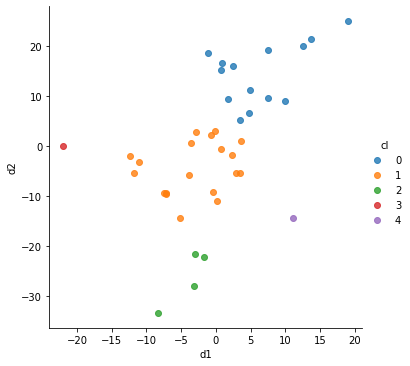

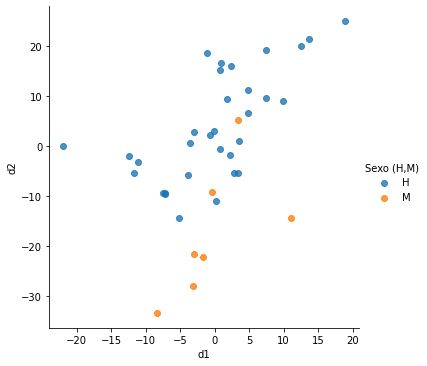

In [33]:
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='Sexo (H,M)')

In [34]:
df['cl'] = cluster.fit_predict(Xs[varc])

In [35]:
df.cl.value_counts()

3    15
1    14
2     8
4     1
0     1
Name: cl, dtype: int64

## Modelos Gaussianos Mixtos

Para este modelo consideramos *k* clusters, por lo que cada cluster tendrá un conjunto de variables que a su vez seguirá una distribución, supondremos que esa es la gaussiana. El entrenamiento consistirá en encontrar valores estimados para los parámetros de la distribución normal. Así después a cada elemento muestral se le calcula la probabilidad de pertenecer a cada cluster.

In [36]:
from sklearn.mixture import GaussianMixture

In [37]:
df = pd.read_excel('datos/Datos Antropométricos.xlsx')

In [38]:
varc = ['Estatura (cm)', 'Peso (kg)', 'Talla Zapato (27,28,etc)', 'Edad']

In [39]:
X = df[varc].copy()

In [40]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)

pca = PCA(n_components=2)
pca.fit(Xs)
print(pca.explained_variance_ratio_.cumsum())

Xp = pd.DataFrame(pca.transform(Xs),columns=['d1','d2'])

mds = MDS(n_components=2,n_jobs=-1)
tsne = TSNE(n_components=2,n_jobs=-1)

Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])

[0.44272375 0.70328042]


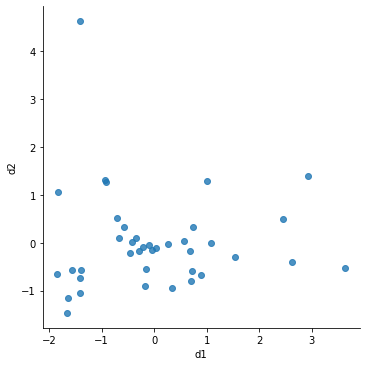

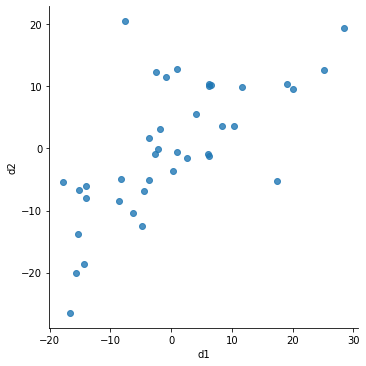

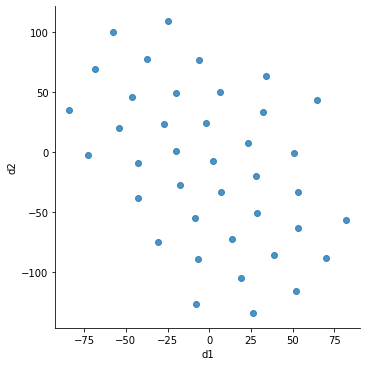

In [41]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

In [42]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

In [43]:
cluster = GaussianMixture(n_components=5)

In [44]:
Xs['cl'] = Xp['cl'] = Xm['cl'] = Xt['cl'] = cluster.fit_predict(Xs)
Xs['Sexo (H,M)'] = Xp['Sexo (H,M)'] = Xm['Sexo (H,M)'] = Xt['Sexo (H,M)'] = df['Sexo (H,M)']

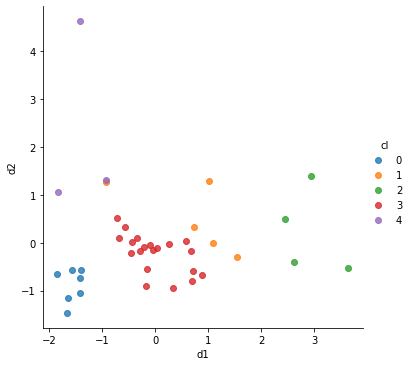

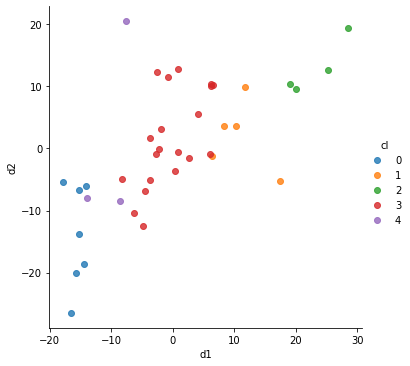

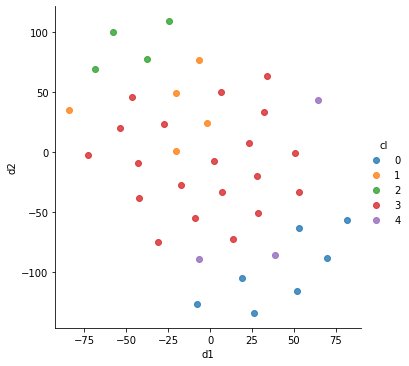

In [45]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

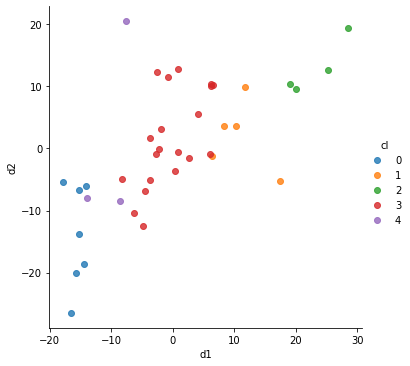

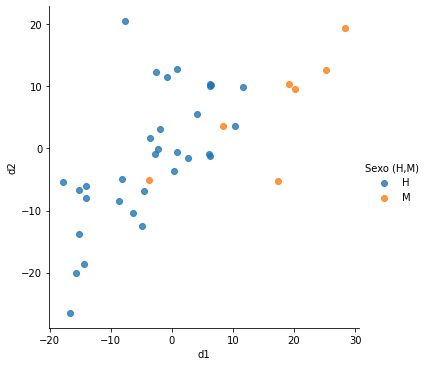

In [46]:
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='Sexo (H,M)')

In [47]:
df['cl'] = cluster.predict(Xs[varc])

In [48]:
df[[f'p_cl{i}' for i in range(5)]] = cluster.predict_proba(Xs[varc])

In [49]:
df.head()

,Estatura (cm),Peso (kg),"Talla Zapato (27,28,etc)",Edad,"Sexo (H,M)",cl,p_cl0,p_cl1,p_cl2,p_cl3,p_cl4
0,180,84,28.0,21,H,0,9.999994e-01,0.000000,0.0,5.626388e-07,0.0
1,172,80,27.0,23,H,3,1.330544e-19,0.000000,0.0,1.000000e+00,0.0
2,170,60,26.0,21,H,3,5.227257e-71,0.000000,0.0,1.000000e+00,0.0
3,160,65,40.0,23,M,1,0.000000e+00,1.000000,0.0,1.314608e-84,0.0
4,165,65,25.5,23,M,1,8.606943e-88,0.997473,0.0,2.527128e-03,0.0


In [50]:
cluster.means_

array([[0.80645244, 0.80714242, 0.27731143, 0.07142753],
       [0.34833719, 0.35660989, 0.32374017, 0.21668368],
       [0.08064516, 0.12916667, 0.02205882, 0.1875    ],
       [0.61444357, 0.46164882, 0.2308596 , 0.12502547],
       [0.86021525, 0.53888865, 0.32352955, 0.63888917]])

In [51]:
cluster.covariances_

array([[[ 1.36772847e-02, -1.21352450e-02,  4.06587123e-04,
         -1.15199194e-03],
        [-1.21352450e-02,  1.25294374e-02, -1.99918971e-05,
          1.07704917e-03],
        [ 4.06587123e-04, -1.99918971e-05,  9.54313969e-04,
         -1.60061996e-03],
        [-1.15199194e-03,  1.07704917e-03, -1.60061996e-03,
          4.81955838e-03]],

       [[ 3.91670087e-03, -2.82131098e-04, -2.08916055e-02,
          3.23655911e-04],
        [-2.82131098e-04,  4.06575104e-03,  2.85464369e-03,
          3.00049984e-03],
        [-2.08916055e-02,  2.85464369e-03,  1.14993035e-01,
         -6.38485179e-03],
        [ 3.23655911e-04,  3.00049984e-03, -6.38485179e-03,
          1.27913355e-02]],

       [[ 4.42347659e-03,  5.04032258e-03,  3.55787476e-04,
         -3.36021505e-04],
        [ 5.04032258e-03,  6.71975000e-03,  9.49754902e-04,
          4.60069444e-03],
        [ 3.55787476e-04,  9.49754902e-04,  5.95723183e-04,
          2.60416667e-03],
        [-3.36021505e-04,  4.60069444e-

In [52]:
cluster.weights_

array([0.17948486, 0.12804006, 0.1025641 , 0.51298803, 0.07692294])

## Perfilamiento

In [176]:
vard = ['Sexo (H,M)']

In [177]:
df['cl'].value_counts(False).sort_index()

0    22
1    11
2     1
3     1
4     4
Name: cl, dtype: int64

In [178]:
df[['cl']+varc].groupby('cl').mean()

,Estatura (cm),Peso (kg),"Talla Zapato (27,28,etc)",Edad
cl,,,,
0,170.636364,68.454545,26.818182,22.545455
1,177.000000,88.454545,27.318182,23.181818
2,160.000000,65.000000,40.000000,23.000000
3,184.000000,58.000000,30.000000,33.000000
4,155.500000,50.750000,23.375000,23.250000


In [179]:
df[varc].mean().to_frame().T

,Estatura (cm),Peso (kg),"Talla Zapato (27,28,etc)",Edad
0,170.948718,71.923077,27.025641,23.076923


In [181]:
pd.concat([df[['cl']+varc].groupby('cl').mean(),df[varc].mean().to_frame().T],ignore_index=True)#.to_clipboard()

,Estatura (cm),Peso (kg),"Talla Zapato (27,28,etc)",Edad
0,170.636364,68.454545,26.818182,22.545455
1,177.000000,88.454545,27.318182,23.181818
2,160.000000,65.000000,40.000000,23.000000
3,184.000000,58.000000,30.000000,33.000000
4,155.500000,50.750000,23.375000,23.250000
5,170.948718,71.923077,27.025641,23.076923


In [182]:
df.pivot_table(index='cl',columns=vard,values='Edad',aggfunc='count',fill_value=0)#.to_clipboard()

"Sexo (H,M)",H,M
cl,,
0,20,2
1,11,0
2,0,1
3,1,0
4,0,4
